### Conv_2_block

In [1]:
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch
import torch.optim as optim
from torch.optim import Adam

def conv_2_block(in_dim, out_dim):
  model = nn.Sequential(
      nn.Conv2d(in_dim, out_dim, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(out_dim, out_dim, kernel_size=3, padding=1), ## kernel_size = 3, padding = 1을 사용하면, (height, width)가 변하지 않는다. => 입력과 출력, 높이와 너비가 전부 바뀌지 않은 상태에서 특징을 뽑는다.
      nn.ReLU(),
      nn.MaxPool2d(2,2)  ## kernel_size = 2, stride  =2 인 경우, (hieght, width)가 절반으로 줄어든다.
  )
  return model

### Conv_3_block

In [2]:
def conv_3_block(in_dim, out_dim):
  model = nn.Sequential(
      nn.Conv2d(in_dim, out_dim, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(out_dim, out_dim, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(out_dim, out_dim, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(2,2)
  )
  return model

### Define VGG16

In [3]:
class VGG(nn.Module):
  def __init__(self, base_dim, num_classes=10):
    super(VGG, self).__init__()
    self.feature = nn.Sequential(
        conv_2_block(3, base_dim),            ## 크기가 절반으로 준다. (MaxPool2d(2,2) 때문)
        conv_2_block(base_dim, 2*base_dim),   ## 크기가 절반으로 준다.  => 지역적인 특징을 뽑는다. 그러나, 더 많이 뽑기 위해 채널을 2배씩 늘린다.
        conv_3_block(2*base_dim, 4*base_dim), ## 크기가 절반으로 준다.
        conv_3_block(4*base_dim, 8*base_dim), ## 크기가 절반으로 준다.
        conv_3_block(8*base_dim, 8*base_dim), ## 크기가 절반으로 준다. => 이번엔 채널은 늘어나지 않고 특징만 다시 한 번 뽑는다.
    )
    self.fc_layer = nn.Sequential(
        nn.Linear(8*base_dim*1*1, 4096),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(4096, 1000),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(1000, num_classes),
    )

  def forward(self, x):
    x = self.feature(x)
    x = x.view(x.size(0), -1)
    x = self.fc_layer(x)
    return x

### model, loss, optimizer 선언

In [4]:
batch_size = 100
learning_rate = 0.0002
num_epoch = 100

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = VGG(base_dim=64).to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### load CIFAR10 dataset

- Train/Test 데이터 셋 정의

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

cifar10_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
cifar10_test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:06<00:00, 24.9MB/s]


- Train 데이터 셋 시각화

In [7]:
train_loader = torch.utils.data.DataLoader(cifar10_train, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(cifar10_test, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

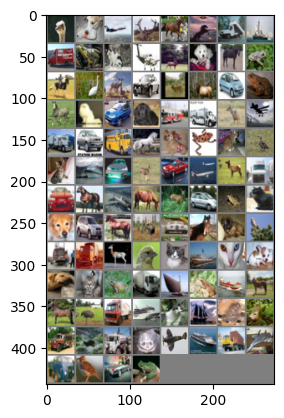

 bird   dog plane  deer horse horse truck  ship truck  frog   cat plane  deer   dog horse  frog horse  bird  deer   car  deer  deer   car  frog horse   cat   car   dog truck truck  deer plane truck   car truck horse   dog  frog   cat  bird   cat  ship   car  deer   car plane  deer truck   car horse plane horse  deer   car  frog   cat   dog   car horse  deer   car horse   dog  bird truck truck  deer  bird   cat  ship   cat   dog   dog   cat  frog truck  ship  frog  ship horse horse  bird truck  ship   cat  ship  frog  deer truck  bird truck  ship plane  ship truck plane truck  bird   car  frog


In [8]:
def imshow(img):
  img = img / 2 + 0.5   ## 정규화 제거
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))  ## 이미지 채널 차원 변경 => Pytorch는 (C,H,W) 형식,  Matplotlib은 (H,W,C) 형식
  plt.show()

dataiter = iter(train_loader) ## 하나씩 꺼내기 위한 iterator 생성
images, labels = next(dataiter) ## next를 통해 다음 batch를 가져옴

imshow(torchvision.utils.make_grid(images))  ## batch로 묶인 이미지들을 하나의 그리드 형태로 변환하여 보여줌

print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

### Train & Test

- Train

In [9]:
loss_arr = []
for i in range(num_epoch):
  for j, [image, label] in enumerate(train_loader):
    x = image.to(device)
    y_ = label.to(device)

    optimizer.zero_grad()
    output = model.forward(x)
    loss = loss_func(output, y_)
    loss.backward()
    optimizer.step()

  if i % 10 == 0:
    print(loss)
    loss_arr.append(loss.cpu().detach().numpy())

tensor(1.9075, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3335, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1077, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0190, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0090, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0457, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0076, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1244, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0076, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)


- loss 시각화

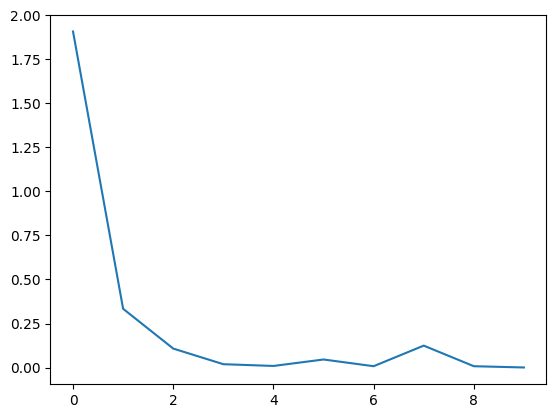

In [10]:
plt.plot(loss_arr)
plt.show()

- test 결과

In [11]:
correct = 0
total = 0

model.eval()

with torch.no_grad():
  for image, label in test_loader:

    x = image.to(device)
    y = label.to(device)

    output = model.forward(x)
    _, output_index = torch.max(output, 1)

    total += label.size(0)
    correct += (output_index == y).sum().float()

  print("Accuracy of Test Data: {}%".format(100*correct/total))

Accuracy of Test Data: 81.32999420166016%
